In [2]:
import pandas as pd
import networkx as nx

# Charger les fichiers
df_edges = pd.read_csv("../Data/processed/trajets_stations_pollution.csv")
df_nodes = pd.read_csv("../Data/processed/stations_qgis.csv")

# Nettoyage des noms (strip des espaces inutiles)
df_nodes['Nom de la Station'] = df_nodes['Nom de la Station'].str.strip()
df_edges['station1'] = df_edges['station1'].str.strip()
df_edges['station2'] = df_edges['station2'].str.strip()


In [3]:
# Création du graphe
G = nx.Graph()

# Ajout des noeuds avec leurs attributs
for _, row in df_nodes.iterrows():
    station = row['Nom de la Station']
    pollution_num = row['pollution_num']
    lat = row['stop_lat']
    lon = row['stop_lon']
    G.add_node(station, pollution=pollution_num, latitude=lat, longitude=lon)

# Ajout des arêtes avec les attributs pollution et temps
for _, row in df_edges.iterrows():
    station1 = row['station1']
    station2 = row['station2']   
    # Vérification : les deux stations doivent exister comme noeuds
    if station1 in G.nodes and station2 in G.nodes:
        G.add_edge(station1, station2)

# Résumé du graphe
nb_nodes = G.number_of_nodes()
nb_edges = G.number_of_edges()
sample_nodes = list(G.nodes(data=True))[:5]

nb_nodes, nb_edges, sample_nodes

(320,
 376,
 [('Arts et Métiers',
   {'pollution': 2,
    'latitude': 48.86529961264491,
    'longitude': 2.3565081436435467}),
  ('Avron',
   {'pollution': 2,
    'latitude': 48.85164854359716,
    'longitude': 2.3981875566593973}),
  ('Barbès - Rochechouart',
   {'pollution': 2,
    'latitude': 48.88385234986188,
    'longitude': 2.350573400888514}),
  ('Boissière',
   {'pollution': 2,
    'latitude': 48.8668483434173,
    'longitude': 2.2900328376074373}),
  ('Botzaris',
   {'pollution': 2,
    'latitude': 48.879534991268365,
    'longitude': 2.388900951315739})])

In [4]:
from scipy.sparse.csgraph import laplacian
from scipy.linalg import eigh

# Matrice d’adjacence binaire (poids = 1 si connecté)
A = nx.to_numpy_array(G, weight=None)

# Calcul du Laplacien normalisé
L = laplacian(A, normed=True)

# Décomposition spectrale
eigvals, eigvecs = eigh(L)

# Affichage des 10 plus petites valeurs propres
eigvals[:10]


array([4.44089210e-16, 5.35704744e-03, 6.51452990e-03, 8.45771035e-03,
       9.89938144e-03, 1.19714408e-02, 1.45287908e-02, 1.65130679e-02,
       1.75247938e-02, 2.05103663e-02])

[ 3.47308498e-02  4.79355269e-02  3.20547074e-02 -6.42283750e-02
  6.44193095e-02 -7.13467870e-02 -1.36945183e-01  8.26541884e-03
 -2.23037380e-02  3.18888789e-03 -2.19723374e-02  1.33232911e-02
 -8.27865386e-02 -8.79437497e-02  3.61568757e-02  2.09862310e-02
  1.83849277e-02 -1.83662733e-03 -3.63581952e-02 -3.95167799e-02
  5.34588329e-02 -5.42304818e-02  1.30868298e-01  5.19876065e-02
 -6.40487486e-02  1.61242715e-02  3.50910928e-02 -4.87645400e-02
  3.88266213e-02  6.58125017e-02  1.96325465e-02  4.15725957e-02
 -4.64301223e-02  3.65357009e-02  8.48589142e-03 -4.85853686e-02
 -1.15068131e-01  6.28762876e-02 -9.88916572e-02 -9.41261400e-02
  1.16218337e-02 -2.05232974e-02 -6.13112034e-02 -1.47227072e-02
 -1.53049741e-02  6.86420214e-02  2.51961273e-02  1.47337546e-01
  1.39852116e-01  2.69853338e-02  2.01028293e-02 -1.85391983e-01
 -9.07201123e-02  8.10759000e-02 -4.22806172e-02 -2.24592983e-03
 -7.30392597e-02  6.81825274e-02 -1.98035050e-02  2.48601986e-02
  3.82265396e-03 -2.67128

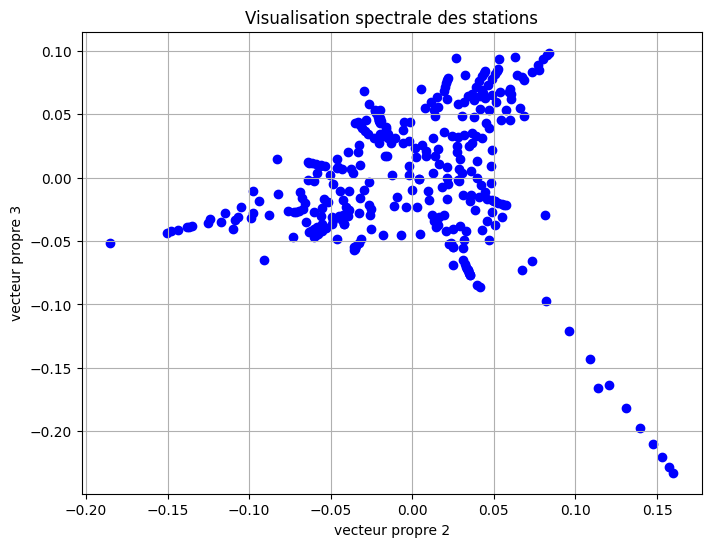

NameError: name 'np' is not defined

In [5]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

#on choisit les vecteurs propres 2 et 3 (pas celui de valeur 0); ces vecteurs montrent les directions principales dans le graphe

vec2 = eigvecs[:, 1]  # 2eme plus petit vecteur propre
vec3 = eigvecs[:, 2]  # 3eme plus petit vecteur propre

print(vec2, vec3)

#  on fait un nuage de points, chaque point est une station, les couleurs representent les zones qui reagissent pareil a la pollution

plt.figure(figsize=(8, 6))
plt.scatter(vec2, vec3, c='blue')
plt.xlabel("vecteur propre 2")
plt.ylabel("vecteur propre 3")
plt.title("Visualisation spectrale des stations")
plt.grid(True)
plt.show()

# clustering avec KMeans pour regrouperr les stations en 3 groupes selon leur position dans le plan spectral

X = np.vstack((vec2, vec3)).T  # on met les deux vecteurs ensemble
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
labels = kmeans.fit_predict(X)

# meme graphe mais avec couleurs selon les clusters trouves
plt.figure(figsize=(8, 6))
plt.scatter(vec2, vec3, c=labels, cmap='viridis')
plt.xlabel("vecteur propre 2")
plt.ylabel("vecteur propre 3")
plt.title("Clustering spectral des stations (3 groupes)")
plt.grid(True)
plt.show()


In [31]:
from sklearn.cluster import KMeans
import pandas as pd

# on applique un clustering k-means sur les vecteurs propres 2 et 3
kmeans = KMeans(n_clusters=3, random_state=0).fit(eigvecs[:, 1:3])
labels = kmeans.labels_

# on reliste les noms des stations et leur cluster (groupe spectral)
# on utilise df_merged qui contient les noms de stations connectees

# on prend tous les noms de stations dans l'ordre du graphe
stations = list(G.nodes)

# on fait un tableau avec les noms de stations et leur groupe spectral
df_clusters = pd.DataFrame({
    "station": stations,
    "cluster": labels
})

# on affiche les 10 premieres lignes pour verifier
df_clusters.head(10)

# on recupere l'ordre exact des noeuds dans la matrice A
# cet ordre est le meme que celui utilise pour les vecteurs propres
station_order = list(G.nodes)  # on garde l’ordre des nœuds tel qu’il est dans G

# on recalcule proprement l'ordre des stations depuis le graphe
station_list = list(G.nodes())

# on fait un tableau correct avec les labels de cluster selon l'ordre des vecteurs propres
df_clusters_corrected = pd.DataFrame({
    "station": station_list,
    "cluster": labels
})

# on compte le nombre de stations par cluster
df_clusters_corrected['cluster'].value_counts().sort_index()


cluster
0    208
1    100
2     12
Name: count, dtype: int64

In [8]:
# Lister les stations par cluster
stations_by_cluster = df_clusters_corrected.groupby("cluster")["station"].apply(list)

# Recuperer les coordonnees depuis df_nodes pour QGIS
# On prend toutes les stations avec leur pollution et leurs coordonnees

# On extrait les infos géographiques et pollution
stations_geo = df_nodes[["Nom de la Station", "pollution_num", "stop_lat", "stop_lon"]].rename(
    columns={
        "Nom de la Station": "station",
        "pollution_num": "pollution",
        "stop_lat": "lat",
        "stop_lon": "lon"
    }
)

# Joindre les clusters
stations_geo_clustered = pd.merge(df_clusters_corrected, stations_geo, on="station", how="left")

# Graphe spectral coloré par pollution (par station)
# On récupère les coordonnées spectrales (vecteurs propres)
station_list = list(G.nodes())
df_plot = pd.DataFrame({
    "station": station_list,
    "x": eigvecs[:, 1],
    "y": eigvecs[:, 2]
})

# Fusion avec pollution réelle par station (depuis df_nodes)
df_plot = pd.merge(df_plot, stations_geo[["station", "pollution"]], on="station", how="left")

# Ecriture d'une analyse auto + affichage resultat tableau QGIS
stations_geo_clustered.to_csv("../Data/processed/stations_qgis_clusters.csv", index=False)

# Affichage résultats
stations_by_cluster, df_plot.head()


NameError: name 'df_clusters_corrected' is not defined